In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from pathlib import Path

import warnings
warnings.filterwarnings('once')

In [2]:
new_df = pd.read_csv('./resize_512.csv')

In [5]:
new_path = Path('./data/train/train_512/')
new_path.mkdir(exist_ok=True)

In [6]:
def read_im(imid):
    path = str(new_path)+'/'+str(imid)+'.jpg'
    im = cv2.imread(path)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [7]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)

In [8]:
def show_corner_bb(im, bbox):
    plt.imshow(im)
    for bb in bbox:
        plt.gca().add_patch(create_corner_rect(bb))

In [9]:
def get_im_bb(imid, df):
    """
    Get single image and bbox based on path and df.
    """
    im = read_im(imid)
    bboxes = df.loc[df.image_id == imid, ["x_min", "y_min", "x_max", "y_max"]].values
    return im, bboxes

In [10]:
imid = "44c60402e"
im, bboxes = get_im_bb(imid, new_df)
im.shape, len(bboxes)

((512, 512, 3), 60)

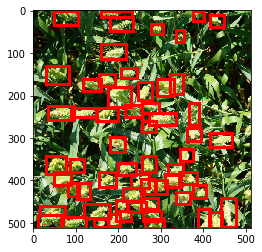

In [11]:
show_corner_bb(im,bboxes)

### Train Test Split

In [12]:
# train test split 0.8/0.2
image_ids = new_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [13]:
valid_df = new_df[new_df['image_id'].isin(valid_ids)]
train_df = new_df[new_df['image_id'].isin(train_ids)]

### Dataset

In [14]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        #print(image_id)
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = image.astype(np.float32)
        image /= 255.0 #normalization

        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        
        area = records[['area']].values
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)


        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]


### Augmentation

In [16]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(p=0.5),
        ToTensorV2(p=1.0)
    ], 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [17]:
train_dataset = WheatDataset(train_df, './data/train/train_512', get_train_transform())
valid_dataset = WheatDataset(valid_df, './data/train/train_512', get_valid_transform())

In [18]:
train_dataset[0]

(tensor([[[0.2667, 0.2667, 0.2863,  ..., 0.1843, 0.1451, 0.1059],
          [0.2627, 0.2588, 0.2745,  ..., 0.1529, 0.1255, 0.0941],
          [0.2980, 0.2784, 0.2549,  ..., 0.1137, 0.0980, 0.0784],
          ...,
          [0.4784, 0.5137, 0.4824,  ..., 0.2275, 0.2196, 0.2235],
          [0.5922, 0.5725, 0.4863,  ..., 0.2196, 0.2235, 0.2275],
          [0.4980, 0.4471, 0.3608,  ..., 0.2235, 0.2353, 0.2510]],
 
         [[0.3765, 0.3569, 0.3569,  ..., 0.1725, 0.1294, 0.0902],
          [0.3647, 0.3490, 0.3529,  ..., 0.1412, 0.1098, 0.0784],
          [0.3804, 0.3608, 0.3686,  ..., 0.1098, 0.0824, 0.0627],
          ...,
          [0.6706, 0.7059, 0.6824,  ..., 0.2235, 0.2196, 0.2235],
          [0.8157, 0.7922, 0.7059,  ..., 0.2196, 0.2157, 0.2196],
          [0.7333, 0.6784, 0.5882,  ..., 0.2235, 0.2275, 0.2431]],
 
         [[0.2863, 0.2706, 0.2667,  ..., 0.1804, 0.1490, 0.1098],
          [0.2706, 0.2627, 0.2784,  ..., 0.1490, 0.1294, 0.0980],
          [0.2824, 0.2745, 0.3059,  ...,

In [19]:
valid_dataset[0]

(tensor([[[0.0392, 0.0431, 0.0471,  ..., 0.0118, 0.0078, 0.0078],
          [0.0471, 0.0510, 0.0667,  ..., 0.0196, 0.0157, 0.0196],
          [0.0706, 0.0510, 0.0549,  ..., 0.0235, 0.0196, 0.0157],
          ...,
          [0.0039, 0.1686, 0.2706,  ..., 0.2039, 0.2157, 0.2431],
          [0.0000, 0.0706, 0.2078,  ..., 0.1608, 0.2471, 0.2824],
          [0.0000, 0.0000, 0.1725,  ..., 0.1098, 0.2863, 0.3255]],
 
         [[0.1020, 0.1059, 0.1059,  ..., 0.0353, 0.0314, 0.0314],
          [0.1059, 0.1098, 0.1216,  ..., 0.0431, 0.0392, 0.0431],
          [0.1137, 0.0941, 0.0980,  ..., 0.0471, 0.0431, 0.0392],
          ...,
          [0.1137, 0.2863, 0.3882,  ..., 0.3765, 0.3922, 0.4235],
          [0.0706, 0.1725, 0.3098,  ..., 0.3333, 0.4235, 0.4706],
          [0.0784, 0.0784, 0.2627,  ..., 0.2784, 0.4627, 0.5137]],
 
         [[0.0353, 0.0392, 0.0510,  ..., 0.0157, 0.0118, 0.0118],
          [0.0510, 0.0549, 0.0745,  ..., 0.0235, 0.0196, 0.0235],
          [0.0745, 0.0549, 0.0667,  ...,

In [20]:
def collate_fn(batch):
     return tuple(zip(*batch))

In [21]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [35]:
images, targets, image_ids = next(iter(train_data_loader))

In [37]:
images = [torch.as_tensor(image, dtype = torch.float32).cuda() for image in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [23]:
next(iter(valid_data_loader))

((tensor([[[0.0392, 0.0431, 0.0471,  ..., 0.0118, 0.0078, 0.0078],
           [0.0471, 0.0510, 0.0667,  ..., 0.0196, 0.0157, 0.0196],
           [0.0706, 0.0510, 0.0549,  ..., 0.0235, 0.0196, 0.0157],
           ...,
           [0.0039, 0.1686, 0.2706,  ..., 0.2039, 0.2157, 0.2431],
           [0.0000, 0.0706, 0.2078,  ..., 0.1608, 0.2471, 0.2824],
           [0.0000, 0.0000, 0.1725,  ..., 0.1098, 0.2863, 0.3255]],
  
          [[0.1020, 0.1059, 0.1059,  ..., 0.0353, 0.0314, 0.0314],
           [0.1059, 0.1098, 0.1216,  ..., 0.0431, 0.0392, 0.0431],
           [0.1137, 0.0941, 0.0980,  ..., 0.0471, 0.0431, 0.0392],
           ...,
           [0.1137, 0.2863, 0.3882,  ..., 0.3765, 0.3922, 0.4235],
           [0.0706, 0.1725, 0.3098,  ..., 0.3333, 0.4235, 0.4706],
           [0.0784, 0.0784, 0.2627,  ..., 0.2784, 0.4627, 0.5137]],
  
          [[0.0353, 0.0392, 0.0510,  ..., 0.0157, 0.0118, 0.0118],
           [0.0510, 0.0549, 0.0745,  ..., 0.0235, 0.0196, 0.0235],
           [0.0745, 0.

In [47]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [48]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [49]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [50]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [53]:
device = torch.device('cuda')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 10

In [55]:
loss_hist = Averager()
itr = 1
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:        
            images = [torch.as_tensor(image, dtype = torch.float32).cuda() for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            
            
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            
            loss_hist.send(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")
                        
            itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #50 loss: 0.4434010684490204
Iteration #100 loss: 0.643194317817688
Iteration #150 loss: 0.7132841944694519
Iteration #200 loss: 0.7433400750160217
Iteration #250 loss: 0.7711102962493896
Iteration #300 loss: 0.6934417486190796
Iteration #350 loss: 0.3639029264450073
Iteration #400 loss: 0.45067617297172546
Iteration #450 loss: 0.5011265873908997
Iteration #500 loss: 0.5425050854682922
Iteration #550 loss: 0.9608345031738281
Iteration #600 loss: 0.5505987405776978
Iteration #650 loss: 0.63434237241745
Epoch #0 loss: 0.6316701454637321
Iteration #700 loss: 0.6731135845184326
Iteration #750 loss: 0.6581333875656128
Iteration #800 loss: 0.6030663251876831
Iteration #850 loss: 1.1092901229858398
Iteration #900 loss: 0.7224180102348328
Iteration #950 loss: 0.6592181921005249
Iteration #1000 loss: 0.5285942554473877
Iteration #1050 loss: 0.6155033111572266
Iteration #1100 loss: 0.6030310392379761
Iteration #1150 loss: 0.5663962364196777
Iteration #1200 loss: 0.46517807245254517
Ite